In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import wfdb
import pandas as pd
import ast
import random
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics

import data_visualisation as dv
import data_augmentation as da
# from PTBXL import PTBXL
import importlib

importlib.reload(dv)
importlib.reload(da)

2024-05-17 19:14:36.453112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 19:14:36.963287: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-17 19:14:36.963352: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-17 19:14:36.963358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<module 'data_augmentation' from '/home/raaif/Desktop/Uni/y4/FYP/data_augmentation.py'>

In [2]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return noised_drifted_signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

In [12]:
def load_china_data(dir_path, label):
    
    # init array
    data = []
    
    # read all files in the directory
    for file in os.listdir(dir_path):
        path = os.path.join(dir_path, file)
        f = open(path, 'r')
        ecg = np.fromfile(f, dtype=np.int16)
        ecg = np.reshape(ecg, (8, 5000))
        
        ## Downsample to 100hz
        ecg = ecg.reshape(8, 1000, 5)
        ecg = np.mean(ecg, axis=2)
        
        data.append(ecg)
        f.close()
        
    # Convert to numpy array
    data = np.array(data)
    # Reshape to (n_samples, n_samples_per_lead, n_leads)
    data = np.swapaxes(data, 1, 2)
    
    # Calculate remaining leads
    lead_III = data[:,:,1] - data[:,:,0]           # ecg_dict['III'] = ecg_dict['II'] - ecg_dict['I']
    lead_aVR = -0.5 * (data[:,:,0] + data[:,:,1])  # ecg_dict['aVR'] = -0.5 * (ecg_dict['I'] + ecg_dict['II'])
    lead_aVL = data[:,:,0] - 0.5 * data[:,:,1]     # ecg_dict['aVL'] = ecg_dict['I'] - 0.5 * ecg_dict['II']
    lead_aVF = data[:,:,1] - 0.5 * data[:,:,0]     # ecg_dict['aVF'] = ecg_dict['II'] - 0.5 * ecg_dict['I']
    
    # Add remaining leads to data
    data = np.concatenate((data,  
                              np.expand_dims(lead_III, axis=2), 
                              np.expand_dims(lead_aVR, axis=2), 
                              np.expand_dims(lead_aVL, axis=2), 
                              np.expand_dims(lead_aVF, axis=2)), axis=2)
    
    return data, np.full(data.shape[0], label)

In [13]:
# Load the data
brugada_path = 'DAT China/DAT China Brugada ECGs/dat'
RBBB_path = 'DAT China/DAT China RBBB ECGs/datnew'
Normal_path = 'DAT China/Normal/dat'

label_dict = {0: 'Normal', 1: 'Brugada', 2: 'RBBB'}

Normal_data, normal_labels = load_china_data(Normal_path, 0)
brugada_data, brugada_labels = load_china_data(brugada_path, 1)
RBBB_data, RBBB_labels = load_china_data(RBBB_path, 2)

In [14]:
# Downsample for training

#original data
print("Original data")
print("Normal:", Normal_data.shape)
print("RBBB:", RBBB_data.shape)
print("Burgada:", brugada_data.shape)

Normal_ratio = 0.02
RBBB_ratio = 0.01

# get random samples
Normal_downsampled = Normal_data[np.random.choice(Normal_data.shape[0], int(Normal_data.shape[0] * Normal_ratio), replace=False)]
RBBB_downsampled = RBBB_data[np.random.choice(RBBB_data.shape[0], int(RBBB_data.shape[0] * RBBB_ratio), replace=False)]
Bruagada_downsampled = brugada_data

print("\nDownsampled data")
print("Normal:", Normal_downsampled.shape)
print("RBBB:", RBBB_downsampled.shape)
print("Burgada:", Bruagada_downsampled.shape)

Original data
Normal: (9998, 1000, 12)
RBBB: (10000, 1000, 12)
Burgada: (176, 1000, 12)

Downsampled data
Normal: (199, 1000, 12)
RBBB: (100, 1000, 12)
Burgada: (176, 1000, 12)


In [15]:
# shuffle data
np.random.shuffle(Normal_downsampled)
np.random.shuffle(RBBB_downsampled)
np.random.shuffle(Bruagada_downsampled)

data = np.concatenate((Normal_downsampled, RBBB_downsampled, Bruagada_downsampled), axis=0)
labels = np.concatenate((normal_labels[:Normal_downsampled.shape[0]], RBBB_labels[:RBBB_downsampled.shape[0]], brugada_labels), axis=0)

print("\nData shape:", data.shape)
print("Labels shape:", labels.shape)

# shuffle data
permutation = np.random.permutation(data.shape[0])
np.random.shuffle(permutation)

shuffled_data = data[permutation]
shuffled_labels = labels[permutation]


Data shape: (475, 1000, 12)
Labels shape: (475,)


In [16]:
# normalise the data
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(shuffled_data.reshape(-1, shuffled_data.shape[-1]))

X_HB_normalised = X_scaler.transform(shuffled_data.reshape(-1, shuffled_data.shape[-1])).reshape(shuffled_data.shape)

In [17]:
from wfdb import processing

X_HB = []
Y_HB = []
Y_HB_text = []

sampling_rate = 100
window_size = int(sampling_rate * 0.5)

get_text_label = lambda x: label_dict[x]

for i, sample in enumerate(X_HB_normalised):
    print("Progress:", i, "/", X_HB_normalised.shape[0], end="\r")
    xqrs = processing.XQRS(sig=sample[:,0], fs=sampling_rate)
    xqrs.detect(verbose=False)
    qrs_inds = xqrs.qrs_inds
    for indx in qrs_inds:
        if indx + window_size > sample.shape[0] or indx - window_size < 0:
            continue
        X_HB.append(sample[indx-window_size:indx+window_size])
        Y_HB.append(shuffled_labels[i])
        Y_HB_text.append(get_text_label(shuffled_labels[i]))
        
X_HB = np.array(X_HB)
Y_HB = np.array(Y_HB)
Y_HB_text = np.array(Y_HB_text)

print("new data shape")
print(X_HB.shape)
print(Y_HB.shape)
print(Y_HB_text.shape)

new data shape/ 475
(7187, 100, 12)
(7187,)
(7187,)


In [18]:
# get a test, train, validation split
train_split = 0.7
val_split = 0.1
test_split = 0.2

train_data = X_HB[:int(X_HB.shape[0] * train_split)]
train_labels = Y_HB[:int(Y_HB.shape[0] * train_split)]
train_text_labels = Y_HB_text[:int(Y_HB.shape[0] * train_split)]

val_data = X_HB[int(X_HB.shape[0] * train_split):int(X_HB.shape[0] * (train_split + val_split))]
val_labels = Y_HB[int(Y_HB.shape[0] * train_split):int(Y_HB.shape[0] * (train_split + val_split))]
val_text_labels = Y_HB_text[int(Y_HB.shape[0] * train_split):int(Y_HB.shape[0] * (train_split + val_split))]

test_data = X_HB[int(X_HB.shape[0] * (train_split + val_split)):]
test_labels = Y_HB[int(Y_HB.shape[0] * (train_split + val_split)):]
test_text_labels = Y_HB_text[int(Y_HB.shape[0] * (train_split + val_split)):]

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Train text labels shape:", train_text_labels.shape)
print("Val data shape:", val_data.shape)
print("Val labels shape:", val_labels.shape)
print("Val text labels shape:", val_text_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Test text labels shape:", test_text_labels.shape)

Train data shape: (5030, 100, 12)
Train labels shape: (5030,)
Train text labels shape: (5030,)
Val data shape: (719, 100, 12)
Val labels shape: (719,)
Val text labels shape: (719,)
Test data shape: (1438, 100, 12)
Test labels shape: (1438,)
Test text labels shape: (1438,)


In [19]:
# check label distribution in each set

print("Train label distribution")
t = np.unique(train_text_labels, return_counts=True)
for i in range(len(t[0])):
    print(t[0][i], ":", t[1][i], "\t", f'{t[1][i] / (np.sum(t[1])) : .2f}%',)

t = np.unique(val_text_labels, return_counts=True)
print("\nVal label distribution")
for i in range(len(t[0])):
    print(t[0][i], ":", t[1][i], "\t", f'{t[1][i] / (np.sum(t[1])) : .2f}%',)

t = np.unique(test_text_labels, return_counts=True)
print("\nTest label distribution")
for i in range(len(t[0])):
    print(t[0][i], ":", t[1][i], "\t", f'{t[1][i] / (np.sum(t[1])) : .2f}%',)


Train label distribution
Brugada : 1880 	  0.37%
Normal : 2232 	  0.44%
RBBB : 918 	  0.18%

Val label distribution
Brugada : 205 	  0.29%
Normal : 309 	  0.43%
RBBB : 205 	  0.29%

Test label distribution
Brugada : 552 	  0.38%
Normal : 707 	  0.49%
RBBB : 179 	  0.12%


In [20]:
NP_DATA_LR = 'data/DAT_China_1s_window.npz'

save_args = {
    'X_train': train_data,
    'y_train': train_labels,
    'X_val': val_data,
    'y_val': val_labels,
    'X_test': test_data,
    'y_test': test_labels
}

np.savez(NP_DATA_LR, **save_args)

In [36]:
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China.npz'
#NP_DATA = 'data/DAT_China_1s_window.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if k == 'y_train_text' or k=='Y_train_text' or k == 'y_val_text' or k=='Y_val_text' or k == 'y_test_text' or k=='Y_test_text':
            setattr(thismodule, k, data[k])
        else:
            print(k)
            setattr(thismodule, k, data[k].astype(float))

X_train
Y_train
X_val
Y_val
X_test
Y_test


In [40]:
print(np.unique(Y_train, return_counts=True))       
print(np.unique(Y_val, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0., 1., 2.]), array([142, 123,  67]))
(array([0., 1., 2.]), array([18, 19, 10]))
(array([0., 1., 2.]), array([39, 34, 23]))


In [39]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(332, 1000, 12)
(47, 1000, 12)
(96, 1000, 12)


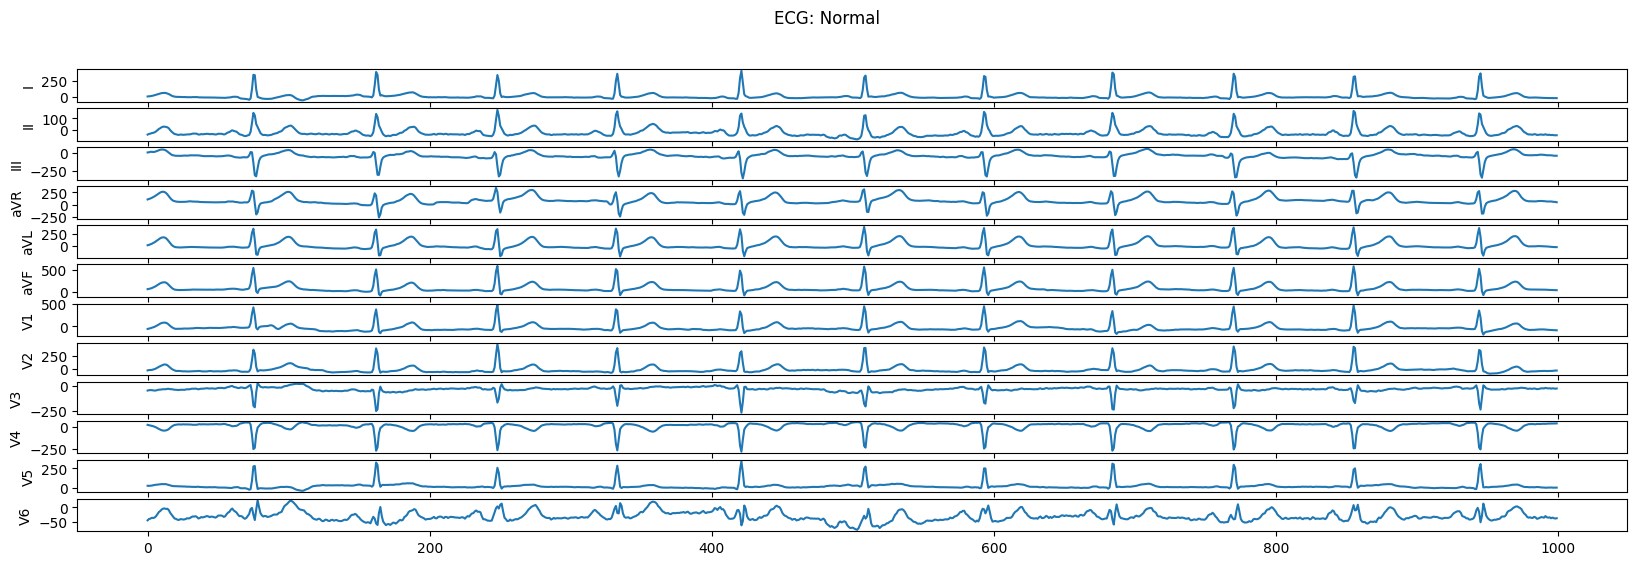

In [38]:
rand_index = np.random.randint(0, X_train.shape[0])
rand_sample = X_train[rand_index]
label = y_train[rand_index]
text_label = "Brugada" if label == 1 else "Normal"


dv.plot_12_lead_ecg(rand_sample, text_label)
    

In [37]:
# define cnn model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

# model for windowed data

def cnn_model(X, num_classes=5, filters = [12, 18, 24], kernels = [5,5,3]):
    
    X = keras.layers.Conv1D(filters=filters[0], kernel_size=kernels[0], input_shape=X.shape[1:])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('leaky_relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[1], kernel_size=kernels[1])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('leaky_relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[2], kernel_size=kernels[2])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('leaky_relu')(X)
    
    features_output = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dropout(0.5)(features_output)
    
    # X = keras.layers.Dense(64, activation='relu')(X)
    # X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(32, activation='leaky_relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    X = keras.layers.Dense(8, activation='leaky_relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    
    return X, features_output

num_classes = 1
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn_model(X_input, num_classes=num_classes)

model = keras.Model(inputs=X_input, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 12)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, 196, 12)           732       
                                                                 
 batch_normalization_24 (Bat  (None, 196, 12)          48        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 196, 12)           0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 98, 12)           0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 94, 18)            1098

In [33]:
#define rnn model

def rnn_model(X, num_classes=1, units = 32):
        
        # X = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=True))(X)
        X = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=False))(X)
        
        # dropout layer
        # X = keras.layers.Dropout(0.5)(X)
        X = keras.layers.Dense(16, activation='relu')(X)
        X = keras.layers.Dropout(0.2)(X)
        X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
        
        return X
    
X_input = keras.Input(shape=X_train.shape[1:])
outputs = rnn_model(X_input)
model = keras.Model(inputs=X_input, outputs=outputs)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200, 12)]         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               11520     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,577
Trainable params: 12,577
Non-trainable params: 0
_______________________________________________________

Epoch 1/20
137/137 [==============================] - 3s 8ms/step - loss: 0.6691 - accuracy: 0.6024 - precision: 0.4458 - recall: 0.3928 - binary_accuracy: 0.6024 - val_loss: 0.7012 - val_accuracy: 0.5646 - val_precision: 0.0323 - val_recall: 0.0041 - val_binary_accuracy: 0.5646
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 0.5781 - accuracy: 0.7030 - precision: 0.6968 - recall: 0.3395 - binary_accuracy: 0.7030 - val_loss: 0.7791 - val_accuracy: 0.5837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.5837
Epoch 3/20
137/137 [==============================] - 1s 6ms/step - loss: 0.4986 - accuracy: 0.7826 - precision: 0.7542 - recall: 0.6080 - binary_accuracy: 0.7826 - val_loss: 0.8515 - val_accuracy: 0.5758 - val_precision: 0.3382 - val_recall: 0.0943 - val_binary_accuracy: 0.5758
Epoch 4/20
137/137 [==============================] - 1s 6ms/step - loss: 0.4245 - accuracy: 0.8225 - precision: 0.7896 - recall: 0.7281 - binary_accura

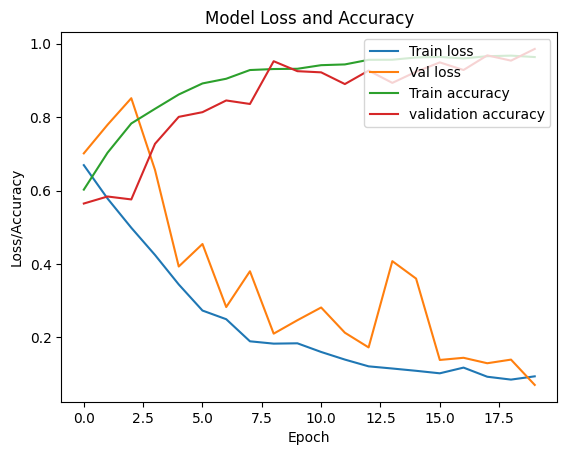

In [38]:
AUGMENT = True

if AUGMENT:
    data_gen = augment_ecg_signal_batch(X_train, y_train, 32)
    history = model.fit(data_gen, validation_data=(X_val, y_val), epochs=20, batch_size=32, steps_per_epoch=len(X_train) // 32)
else:
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# plot the training and validation loss and binary accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss', 'Train accuracy', 'validation accuracy'], loc='upper right')

In [41]:
# evaluate the model
loss, accuracy, precision, recall, binary_accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

print("Loss:", loss)
print("Binary Accuracy:", binary_accuracy)
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("F1 Score:", 2 * (precision * recall) / (precision + recall))
print("Precision:", precision)
print("Recall:", recall)

# auc score
from sklearn.metrics import roc_auc_score



40/40 [==============================] - 0s 836us/step
Loss: 0.2509145140647888
Binary Accuracy: 0.9082934856414795
Accuracy: 0.9082934856414795
ROC AUC Score: 0.973340420022623
F1 Score: 0.8726467591542743
Precision: 0.8995434045791626
Recall: 0.8473118543624878


In [61]:
# define model that randomly guesses
def random_model(X):
    return np.random.randint(0, 2, X.shape[0])

# evaluate the random model
random_labels = random_model(X_test)
loss, accuracy, precision, recall, binary_accuracy = model.evaluate(X_test, random_labels)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Binary Accuracy:", binary_accuracy)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))


40/40 [==============================] - 1s 9ms/step - loss: 4.7389 - accuracy: 0.4912 - precision: 0.5189 - recall: 0.3765 - binary_accuracy: 0.4912
Loss: 4.738865375518799
Accuracy: 0.4912280738353729
Precision: 0.5189075469970703
Recall: 0.3765243887901306
Binary Accuracy: 0.4912280738353729
F1 Score: 0.436395753072828


In [46]:
# define a resnet model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

def resnet_block(X, filters, kernel_size=3):
        
        X_shortcut = X
        
        X = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(X)
        X = keras.layers.BatchNormalization()(X)
        X = keras.layers.Activation('relu')(X)
        
        X = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(X)
        X = keras.layers.BatchNormalization()(X)
        
        X = keras.layers.concatenate([X, X_shortcut])
        X = keras.layers.Activation('relu')(X)
        
        return X
    
def resnet_model(X, num_classes=5, filters = 16, kernels = 5, layers=4, hidden_units=128):
        
        X = keras.layers.Conv1D(filters=filters, kernel_size=kernels, input_shape=X.shape[1:])(X)
        X = keras.layers.BatchNormalization()(X)
        X = keras.layers.Activation('leaky_relu')(X)
        
        X = keras.layers.MaxPooling1D(2)(X)
        
        for i in range(layers):
            X = resnet_block(X, filters, kernel_size=kernels)
            
            if i == 1:
                X = keras.layers.MaxPooling1D(2)(X)
        
        features_output = keras.layers.GlobalAveragePooling1D()(X)
        X = keras.layers.Dropout(0.5)(features_output)
        
        X = keras.layers.Dense(hidden_units, activation='leaky_relu')(X)
        X = keras.layers.Dropout(0.1)(X)
        X = keras.layers.Dense(hidden_units/2, activation='leaky_relu')(X)
        X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
        
        return X, features_output
    
num_classes = 1
X_input = keras.Input(shape=X_train.shape[1:])
outputs2, feature_output2 = resnet_model(X_input, num_classes=num_classes)

model2 = keras.Model(inputs=X_input, outputs=outputs2)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 996, 16)      976         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 996, 16)     64          ['conv1d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 996, 16)      0           ['batch_normalization_27[0]

In [43]:
# convert all RBBB labels (2) to normal (0)

Y_train[Y_train == 2] = 0
Y_val[Y_val == 2] = 0
Y_test[Y_test == 2] = 0

Epoch 1/10


2024-05-17 19:20:24.677948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2024-05-17 19:20:24.867621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-17 19:20:24.886574: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x77353d3b84f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 19:20:24.886594: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-17 19:20:24.889627: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 19:20:24.964508: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

78/78 [==============================] - 6s 14ms/step - loss: 0.6554 - accuracy: 0.6438 - precision: 0.5380 - recall: 0.2829 - binary_accuracy: 0.6438 - val_loss: 0.5736 - val_accuracy: 0.7816 - val_precision: 0.7353 - val_recall: 0.3659 - val_binary_accuracy: 0.7816
Epoch 2/10
78/78 [==============================] - 1s 10ms/step - loss: 0.3402 - accuracy: 0.8554 - precision: 0.8437 - recall: 0.7612 - binary_accuracy: 0.8554 - val_loss: 0.2624 - val_accuracy: 0.9221 - val_precision: 0.9806 - val_recall: 0.7415 - val_binary_accuracy: 0.9221
Epoch 3/10
78/78 [==============================] - 1s 10ms/step - loss: 0.1661 - accuracy: 0.9409 - precision: 0.9370 - recall: 0.8998 - binary_accuracy: 0.9409 - val_loss: 0.2886 - val_accuracy: 0.9332 - val_precision: 0.8428 - val_recall: 0.9415 - val_binary_accuracy: 0.9332
Epoch 4/10
78/78 [==============================] - 1s 10ms/step - loss: 0.1081 - accuracy: 0.9629 - precision: 0.9513 - recall: 0.9431 - binary_accuracy: 0.9629 - val_loss: 

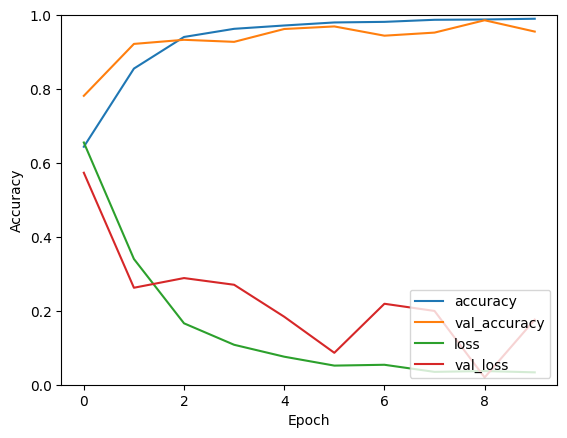

In [31]:
# train model (resnet for 1s windowed data)

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, y_train, batch_size=batch_size)

history = model2.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [32]:
# evaluate model
loss, accuracy, precision, recall, binary_accuracy = model2.evaluate(X_test, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Binary Accuracy:", binary_accuracy)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))

45/45 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.9374 - precision: 0.9773 - recall: 0.8569 - binary_accuracy: 0.9374      
Loss: 0.2888931930065155
Accuracy: 0.9374130964279175
Precision: 0.9772727489471436
Recall: 0.8568840622901917
Binary Accuracy: 0.9374130964279175
F1 Score: 0.9131274250410559


Epoch 1/20
10/10 [==============================] - 0s 23ms/step - loss: 0.1541 - accuracy: 0.9406 - precision: 0.9583 - recall: 0.8915 - binary_accuracy: 0.9406 - val_loss: 0.5480 - val_accuracy: 0.8723 - val_precision: 0.7600 - val_recall: 1.0000 - val_binary_accuracy: 0.8723
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 0.1012 - accuracy: 0.9656 - precision: 0.9310 - recall: 0.9730 - binary_accuracy: 0.9656 - val_loss: 0.4747 - val_accuracy: 0.8936 - val_precision: 0.8182 - val_recall: 0.9474 - val_binary_accuracy: 0.8936
Epoch 3/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2029 - accuracy: 0.9187 - precision: 0.9043 - recall: 0.8739 - binary_accuracy: 0.9187 - val_loss: 0.2922 - val_accuracy: 0.9362 - val_precision: 0.9000 - val_recall: 0.9474 - val_binary_accuracy: 0.9362
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 0.1754 - accuracy: 0.9344 - precision: 0.9636 - recall: 0.8618 - binary_accuracy: 0.9344 -

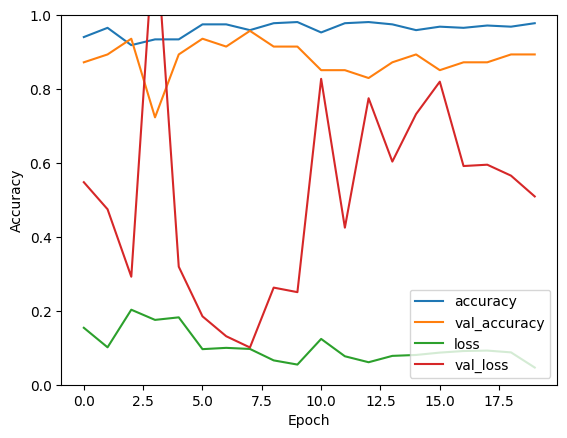

In [49]:
# train model (resnet for full record data)

batch_size = 32

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model2.fit(train_generator, epochs=20, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [50]:
# evaluate model
loss, accuracy, precision, recall, binary_accuracy = model2.evaluate(X_test, Y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Binary Accuracy:", binary_accuracy)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))


3/3 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 0.8438 - precision: 0.7436 - recall: 0.8529 - binary_accuracy: 0.8438
Loss: 0.5405235290527344
Accuracy: 0.84375
Precision: 0.7435897588729858
Recall: 0.8529411554336548
Binary Accuracy: 0.84375
F1 Score: 0.7945205475425465
